In [27]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

WINDOW_SIZE = 30
HORIZON = 30

# Load data
df_raw = pd.read_csv("harga_beras_premium.csv")
df_raw["Tanggal"] = pd.to_datetime(df_raw["Tanggal"], dayfirst=True)
df = df_raw.pivot(index="Tanggal", columns="Provinsi", values="Harga").sort_index()
df = df.fillna(method="ffill")

# Hitung fitur tambahan per provinsi
def add_features(df):
    new_df = df.copy()
    
    for col in df.columns:
        # Delta harga
        new_df[f"{col}_delta"] = df[col].diff()
        
        # Rata-rata 7 hari
        new_df[f"{col}_rolling7"] = df[col].rolling(7).mean()
        
        # Volatilitas 7 hari (rolling std dev)
        new_df[f"{col}_volatility7"] = df[col].rolling(7).std()
    
    # Fitur musiman (mingguan)
    new_df["calweek"] = df.index.isocalendar().week
    new_df["calweek_sin"] = np.sin(2 * np.pi * new_df["calweek"] / 52)
    new_df["calweek_cos"] = np.cos(2 * np.pi * new_df["calweek"] / 52)

    # Fitur musiman bulanan dan kuartalan
    new_df["month"] = df.index.month
    new_df["quarter"] = df.index.quarter

    # Encode bulan dan kuartal sebagai sin/cos (menghindari urutan kategorik palsu)
    new_df["month_sin"] = np.sin(2 * np.pi * new_df["month"] / 12)
    new_df["month_cos"] = np.cos(2 * np.pi * new_df["month"] / 12)

    new_df["quarter_sin"] = np.sin(2 * np.pi * new_df["quarter"] / 4)
    new_df["quarter_cos"] = np.cos(2 * np.pi * new_df["quarter"] / 4)
    
    # Drop kolom asli kategorikal (kalender, bulan, quarter)
    return new_df.drop(columns=["calweek", "month", "quarter"])


def add_anomaly_feature(df, z_thresh=2.5):
    df_anom = df.copy()
    for col in df.columns:
        if "_delta" in col:
            std = df_anom[col].std()
            df_anom[col.replace("_delta", "_anomaly")] = (df_anom[col].abs() > z_thresh * std).astype(int)
    return df_anom


df_feat = add_features(df)
df_feat = add_anomaly_feature(df_feat)
df_feat = df_feat.dropna()


# Split data
df_feat = df_feat.loc["2024-01-20":"2025-05-16"]
train_df = df_feat.loc[:"2024-08-31"]
val_df = df_feat.loc["2024-09-01":"2025-01-31"]
test_df = df_feat.loc["2025-02-01":]


/tmp/ipykernel_5294/3609350660.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/tmp/ipykernel_5294/3609350660.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f"{col}_delta"] = df[col].diff()
/tmp/ipykernel_5294/3609350660.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f"{col}_rolling7"] = df[col].rolling(7).mean()
/tmp/ipykernel_5294/3609350660.py:27: PerformanceWarning: DataFra

In [28]:
from sklearn.preprocessing import StandardScaler

def create_multinode_tensor(df, window_size, horizon, base_columns):
    features = df.columns.tolist()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - window_size - horizon):
        x_window = scaled[i:i+window_size]
        y_future = scaled[i+window_size:i+window_size+horizon]
        
        # Get the target values (province prices only)
        base_col_indices = [df.columns.get_loc(col) for col in base_columns]
        y_target = y_future[:, base_col_indices]
        
        # For feature input, reshape without trying to interpret structure
        # Just keep window, features dimension and let the model handle it
        x_window = x_window.reshape(window_size, -1)
        
        # Add channel dimension for GCN
        x_window_expanded = np.expand_dims(x_window, axis=1)
        
        y_target = y_target.T  # shape: (num_nodes, horizon)
        
        X.append(x_window_expanded)
        y.append(y_target)

    return (
        torch.tensor(np.array(X), dtype=torch.float32),  # shape: (samples, 1, window, features)
        torch.tensor(np.array(y), dtype=torch.float32),  # shape: (samples, nodes, horizon)
        scaler
    )

# Only use province names, not the derived features
base_columns = df.columns.tolist()  # province names only
X_train, y_train, scaler = create_multinode_tensor(train_df, WINDOW_SIZE, HORIZON, base_columns)
X_val, y_val, _ = create_multinode_tensor(val_df, WINDOW_SIZE, HORIZON, base_columns)
X_test, y_test, _ = create_multinode_tensor(test_df, WINDOW_SIZE, HORIZON, base_columns)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: torch.Size([159, 30, 1, 196])
y_train: torch.Size([159, 38, 30])


In [29]:
from torch_geometric.utils import dense_to_sparse

def build_edge_index(df, threshold=0.5):
    base_df = df[df.columns.intersection(base_columns)]
    corr = base_df.corr().abs()
    corr[corr < threshold] = 0
    edge_index, _ = dense_to_sparse(torch.tensor(corr.values, dtype=torch.float32))
    return edge_index

edge_index = build_edge_index(train_df)
print("edge_index:", edge_index.shape)


edge_index: torch.Size([2, 694])


In [30]:
# Refactored GCN-GRU-Attention model without aggressive encoder
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class GCN_GRU_Multihorizon_Refined(nn.Module):
    def __init__(self, num_nodes, in_feats, hidden_dim, out_horizon, edge_index):
        super().__init__()
        self.num_nodes = num_nodes
        self.in_feats = in_feats
        self.hidden_dim = hidden_dim
        self.out_horizon = out_horizon
        self.edge_index = edge_index

        # Feature encoder (light projection)
        self.encoder = nn.Linear(in_feats, 64)  # Project to 64 dims

        self.gat = GATConv(1, hidden_dim // 4, heads=4, concat=True, dropout=0.3)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_horizon)

    def forward(self, x):
        B, _, T, F = x.shape
        x = x.squeeze(1)  # (B, T, F)

        x = self.encoder(x)  # (B, T, 64)

        batch_output = []

        for b in range(B):
            time_outputs = []

            for t in range(T):
                xt = x[b, t]  # (64,)
                node_features = xt.view(-1, 1)[:self.num_nodes]  # ensure correct node count
                xt = self.gat(node_features, self.edge_index)
                xt = xt + node_features  # skip connection
                time_outputs.append(xt)

            node_features_seq = torch.stack(time_outputs, dim=1)  # (num_nodes, T, hidden_dim)

            node_outputs = []
            for n in range(self.num_nodes):
                node_seq = node_features_seq[n]  # (T, hidden_dim)
                out, _ = self.gru(node_seq.unsqueeze(0))  # (1, T, hidden_dim)
                attn_out, _ = self.attn(out, out, out)
                summary = attn_out[:, -1]
                out = self.fc(summary)  # (1, out_horizon)
                node_outputs.append(out)

            batch_output.append(torch.cat(node_outputs, dim=1))

        result = torch.cat(batch_output, dim=0)
        return result.view(B, self.num_nodes, -1)


# Weighted Huber loss
class WeightedHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, pred, target):
        horizon = pred.shape[-1]
        weights = torch.linspace(1.0, 2.0, steps=horizon).to(pred.device)
        loss = nn.functional.huber_loss(pred, target, delta=self.delta, reduction='none')
        weighted = loss * weights
        return weighted.mean()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN_GRU_Multihorizon_Refined(
    num_nodes=len(base_columns),
    in_feats=X_train.shape[-1],
    hidden_dim=64,
    out_horizon=HORIZON,
    edge_index=edge_index.to(device)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = WeightedHuberLoss(delta=5.0)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val)
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")

Epoch 1: Train Loss = 0.5275 | Val Loss = 0.8309
Epoch 10: Train Loss = 0.4640 | Val Loss = 0.8359
Epoch 20: Train Loss = 0.2755 | Val Loss = 0.8877
Epoch 30: Train Loss = 0.2079 | Val Loss = 0.8855


📊 Evaluasi Test Sample 0 - Provinsi Aceh
RMSE (Rp): 58.29
MAE  (Rp): 46.30
MAPE (%): 0.32
R² Score: -0.4846


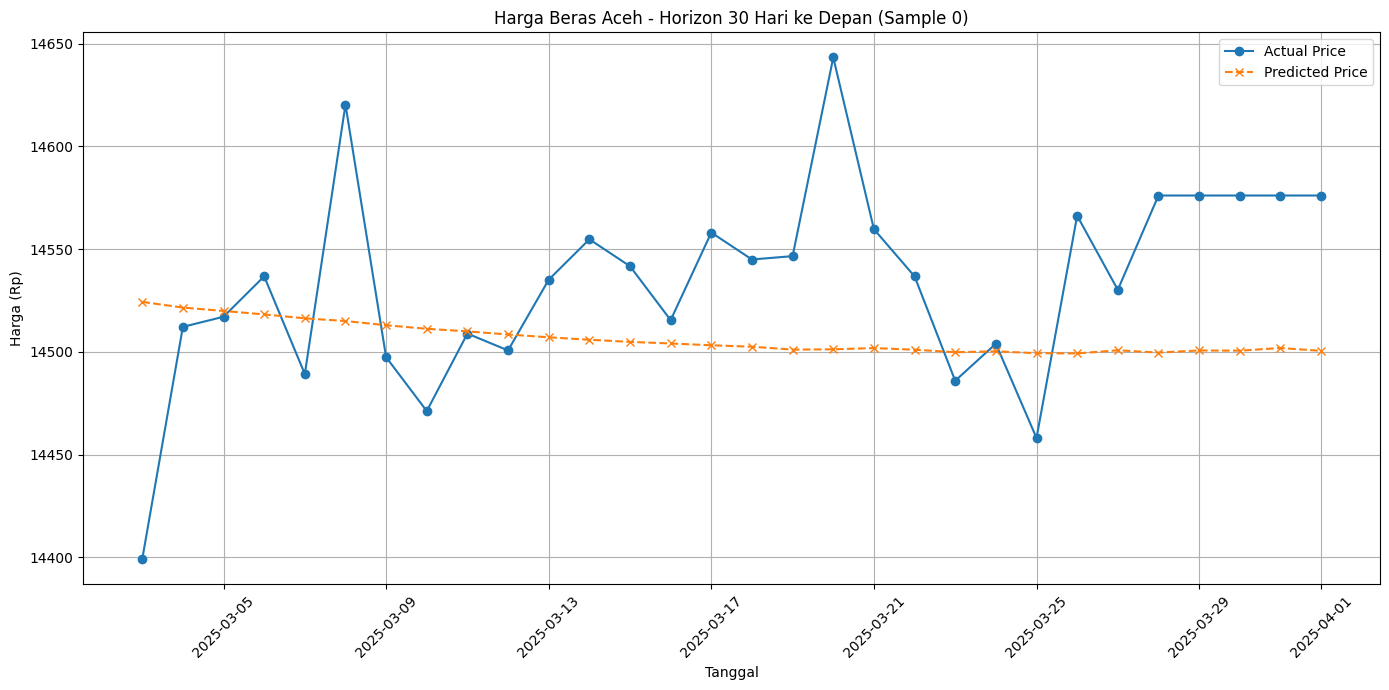

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in eval mode
model.eval()

# Predict on test set
with torch.no_grad():
    pred_test_tensor = model(X_test)
    pred_test = pred_test_tensor.cpu().numpy()
    true_test = y_test.cpu().numpy()

# --- PARAMETER ---
province_to_plot = "Aceh"
sample_idx = 0  # Sample index to plot

# --- Cek indeks provinsi ---
try:
    prov_idx_in_model_output = base_columns.index(province_to_plot)
except ValueError:
    print(f"Province {province_to_plot} not found, fallback ke {base_columns[0]}")
    prov_idx_in_model_output = 0
    province_to_plot = base_columns[0]

scaler_col_idx = train_df.columns.get_loc(province_to_plot)
n_features_scaler = scaler.n_features_in_

# --- Ambil data prediksi dan aktual (scaled) ---
y_pred_sample_scaled = pred_test[sample_idx, prov_idx_in_model_output, :]
y_true_sample_scaled = true_test[sample_idx, prov_idx_in_model_output, :]

# --- Inverse transform ---
pred_matrix_for_inv = np.zeros((HORIZON, n_features_scaler))
true_matrix_for_inv = np.zeros((HORIZON, n_features_scaler))
pred_matrix_for_inv[:, scaler_col_idx] = y_pred_sample_scaled
true_matrix_for_inv[:, scaler_col_idx] = y_true_sample_scaled

pred_inv = scaler.inverse_transform(pred_matrix_for_inv)[:, scaler_col_idx]
true_inv = scaler.inverse_transform(true_matrix_for_inv)[:, scaler_col_idx]

# --- Hitung metrik evaluasi ---
rmse = np.sqrt(mean_squared_error(true_inv, pred_inv))
mae = mean_absolute_error(true_inv, pred_inv)
r2 = r2_score(true_inv, pred_inv)
mape = np.mean(np.abs((true_inv - pred_inv) / true_inv)) * 100

print(f"📊 Evaluasi Test Sample {sample_idx} - Provinsi {province_to_plot}")
print(f"RMSE (Rp): {rmse:,.2f}")
print(f"MAE  (Rp): {mae:,.2f}")
print(f"MAPE (%): {mape:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Generate tanggal prediksi ---
if sample_idx + WINDOW_SIZE < len(test_df.index):
    start_date = test_df.index[sample_idx + WINDOW_SIZE]
    date_range = pd.date_range(start=start_date, periods=HORIZON, freq='D')
else:
    date_range = pd.RangeIndex(start=0, stop=HORIZON)

# --- Visualisasi ---
plt.figure(figsize=(14, 7))
plt.plot(date_range, true_inv, label="Actual Price", marker='o')
plt.plot(date_range, pred_inv, label="Predicted Price", marker='x', linestyle='--')
plt.title(f"Harga Beras {province_to_plot} - Horizon {HORIZON} Hari ke Depan (Sample {sample_idx})")
plt.xlabel("Tanggal")
plt.ylabel("Harga (Rp)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
